In [226]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading Dataset**

In [228]:
data = pd.read_csv('diabetes.csv')

In [229]:
data.shape

(768, 9)

In [230]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [231]:
data.duplicated().sum()

0

In [232]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# **Correlation Graph and Feature Selection**

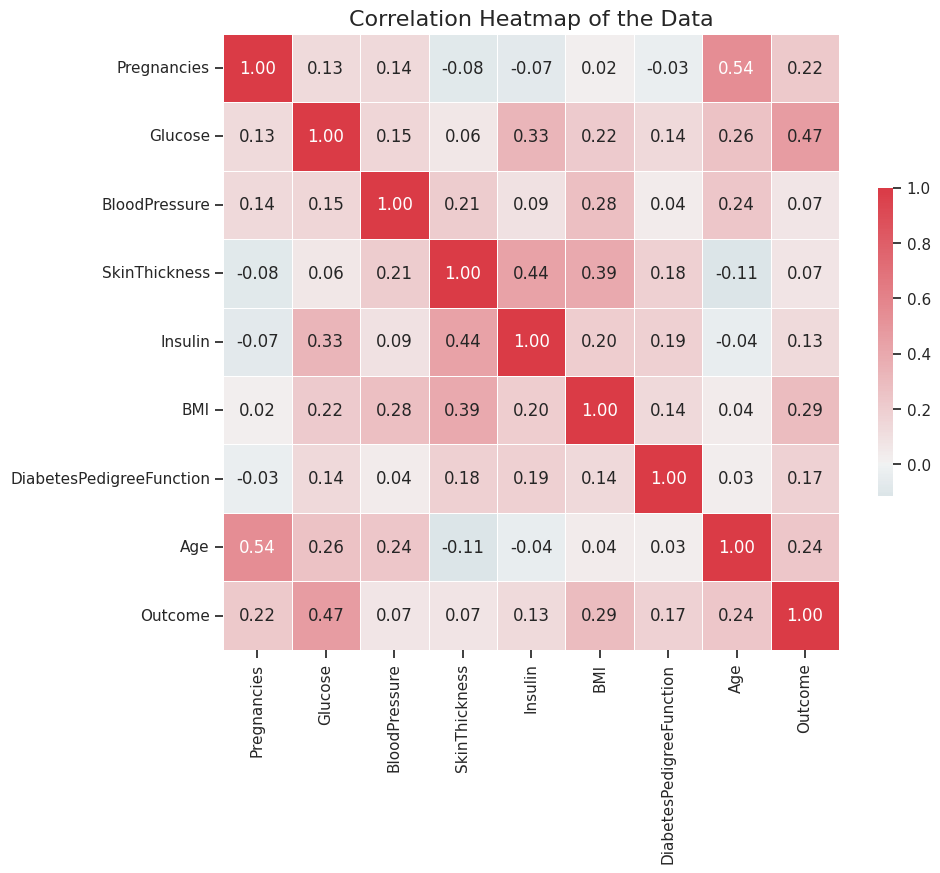

In [233]:
import seaborn as sns
# Compute the correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, cmap=cmap, center=0,
            annot=True, fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap of the Data', fontsize=16)
plt.show()


In [234]:
# Compute the correlation matrix
correlation_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
highly_correlated_features = [column for column in upper.columns if any(upper[column] > 0.3)]

# Print highly correlated features
print("Highly correlated features:")
print(highly_correlated_features)

Highly correlated features:
['Insulin', 'BMI', 'Age', 'Outcome']


<ipython-input-234-4fd634c4715e>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


# **X and y **

In [235]:
X = data.drop(['Outcome'], axis=1)
y = data.Outcome

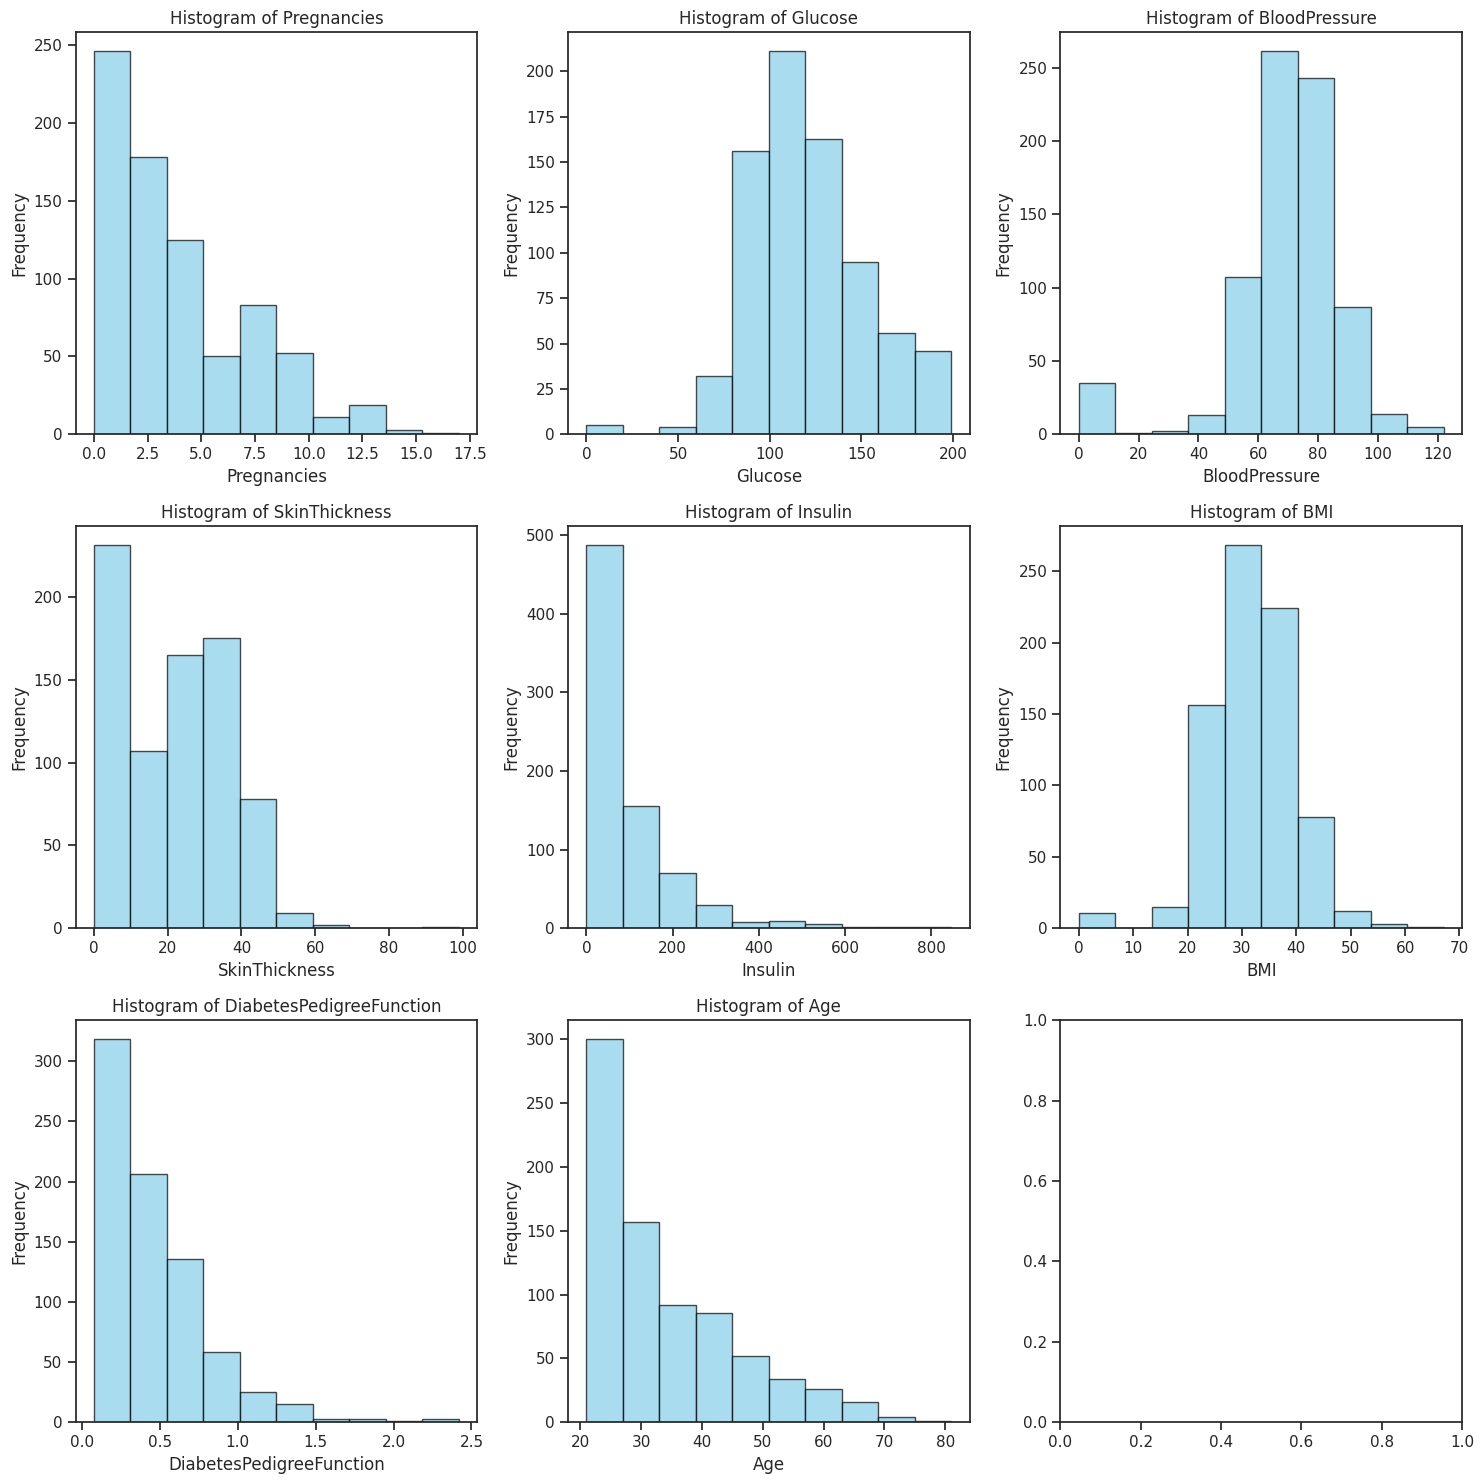

In [236]:
import matplotlib.pyplot as plt
# Plotting histograms for each feature
features = X.columns

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, feature in enumerate(features):
    axs[i].hist(X[feature], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

In [237]:
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Scalar Standardization**

In [239]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

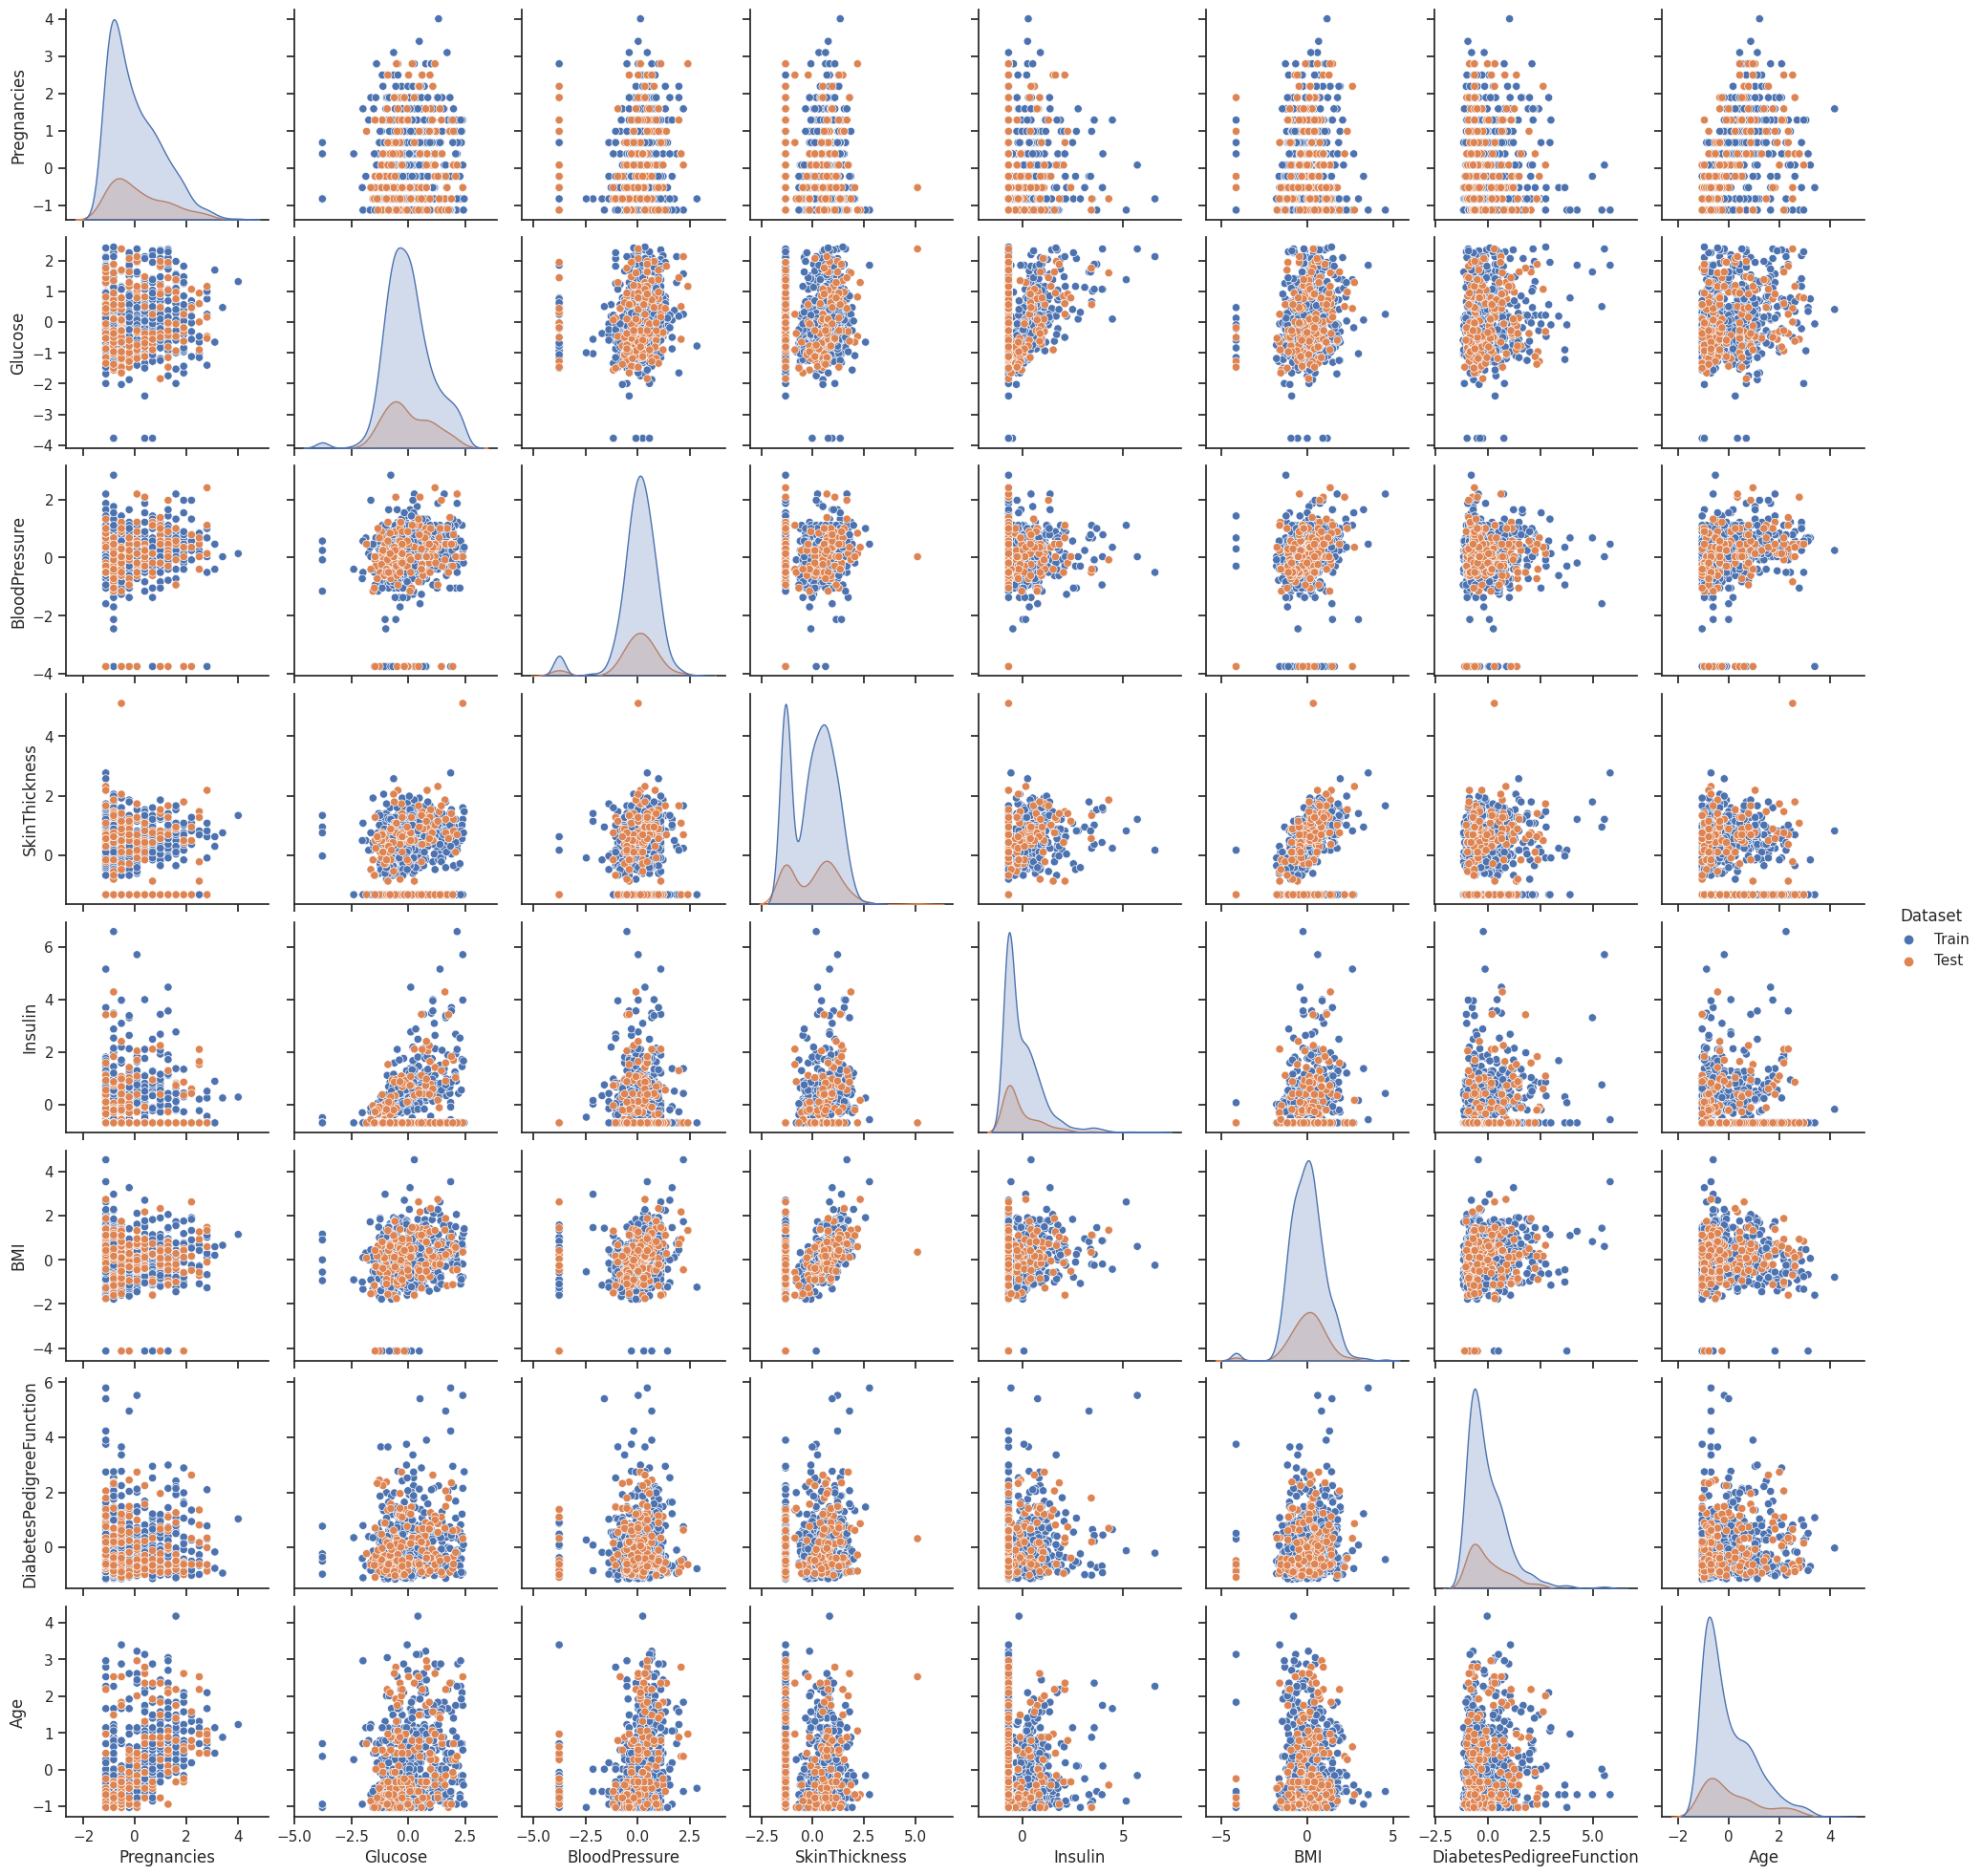

In [240]:
import seaborn as sns
# Convert the arrays back to dataframes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Combine the training and testing dataframes for visualization
X_train_df['Dataset'] = 'Train'
X_test_df['Dataset'] = 'Test'
combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Create pairplot using Seaborn
sns.set(style="ticks")
sns.pairplot(combined_df, hue="Dataset")
plt.show()

# **Decision Tree**

In [241]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7857142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83        99
           1       0.70      0.69      0.70        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.78      0.79      0.79       154


Confusion Matrix:
 [[83 16]
 [17 38]]


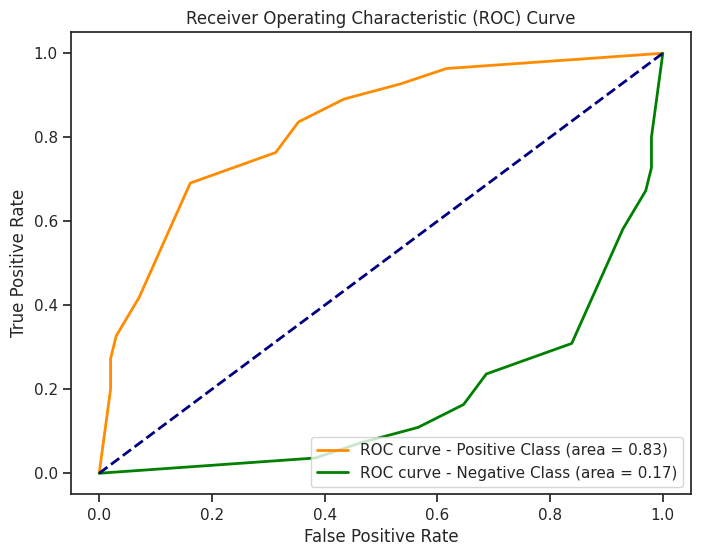

In [242]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for both classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

# Compute ROC curve and ROC area for the negative class
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_pred_prob[:, 0])
roc_auc_neg = roc_auc_score(y_test, y_pred_prob[:, 0])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - Positive Class (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve - Negative Class (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Logistic Regression**

In [243]:
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7532467532467533

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Confusion Matrix:
 [[79 20]
 [18 37]]


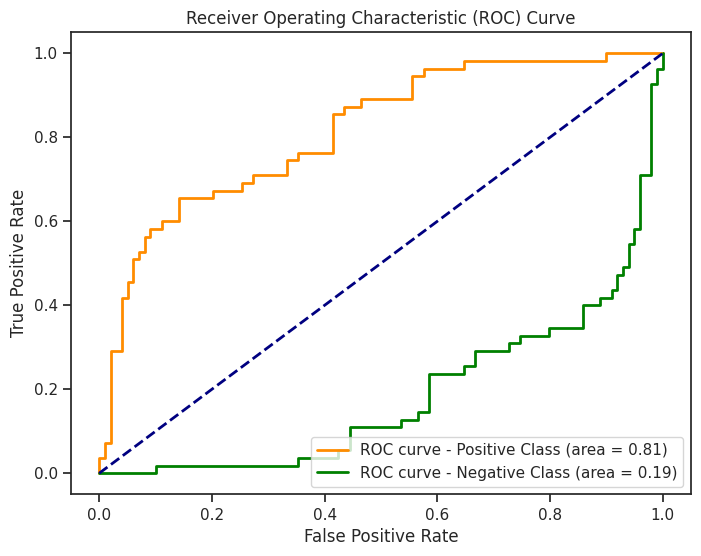

In [244]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for both classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

# Compute ROC curve and ROC area for the negative class
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_pred_prob[:, 0])
roc_auc_neg = roc_auc_score(y_test, y_pred_prob[:, 0])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - Positive Class (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve - Negative Class (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Support Vector Machine**

In [245]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7337662337662337

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        99
           1       0.65      0.56      0.60        55

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154


Confusion Matrix:
 [[82 17]
 [24 31]]


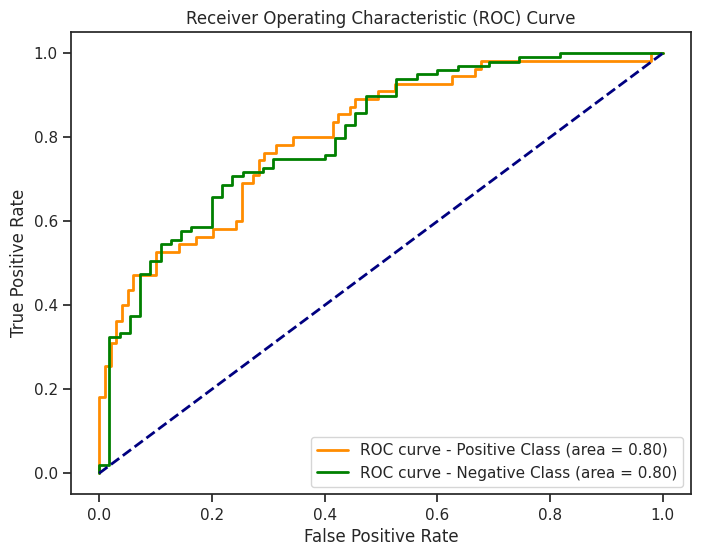

In [246]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute decision function
y_score = model.decision_function(X_test)

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Invert the labels for the ROC curve of the negative class
y_test_negative = 1 - y_test  # Assuming the negative class is labeled as 0

# Compute ROC curve and ROC area for the negative class
fpr_neg, tpr_neg, _ = roc_curve(y_test_negative, -y_score)
roc_auc_neg = roc_auc_score(y_test_negative, -y_score)

# Plot ROC curves for both positive and negative classes
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - Positive Class (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve - Negative Class (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Random Forest**

In [247]:
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7402597402597403

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        99
           1       0.64      0.64      0.64        55

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154


Confusion Matrix:
 [[79 20]
 [20 35]]


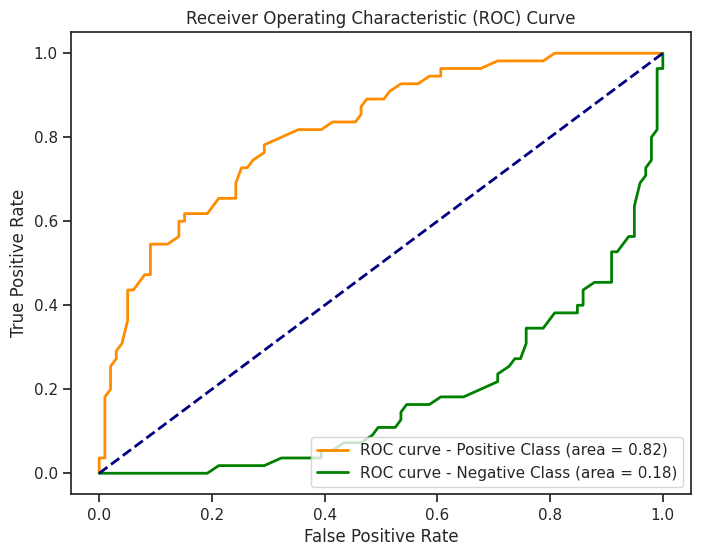

In [248]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for both classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

# Compute ROC curve and ROC area for the negative class
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_pred_prob[:, 0])
roc_auc_neg = roc_auc_score(y_test, y_pred_prob[:, 0])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - Positive Class (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve - Negative Class (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **XGBOOST**

In [249]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7077922077922078

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76        99
           1       0.58      0.65      0.62        55

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.71      0.71       154


Confusion Matrix:
 [[73 26]
 [19 36]]


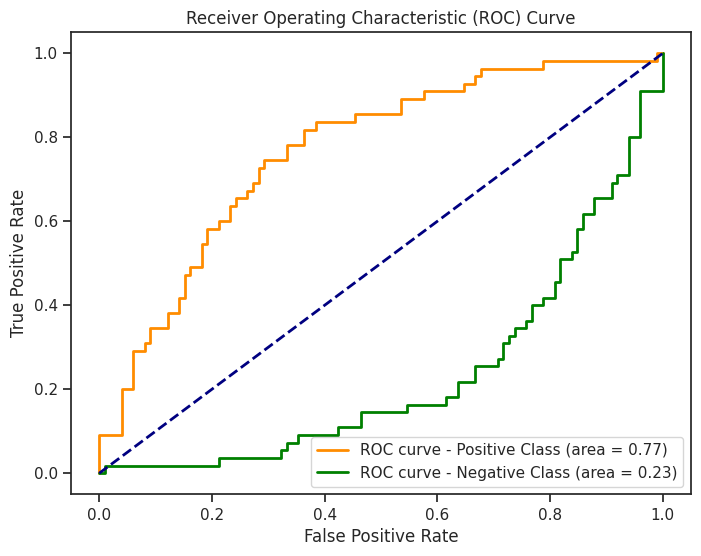

In [250]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for both classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])

# Compute ROC curve and ROC area for the negative class
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_pred_prob[:, 0])
roc_auc_neg = roc_auc_score(y_test, y_pred_prob[:, 0])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - Positive Class (area = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, color='green', lw=2, label='ROC curve - Negative Class (area = %0.2f)' % roc_auc_neg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()